In [1]:
__author__ = "Kexin Yu"
__version__ = "CS341, Stanford, Spring 2018"

In [2]:
import pandas as pd
df_BTC = pd.read_pickle('BTC-USD-60.pkl')

import datetime
df_BTC['date'] = pd.to_datetime(df_BTC['time'],unit='s').dt.date

group_BTC = df_BTC.groupby('date')
BTC_Daily_Price = group_BTC.mean()

BTC_Daily_Price=BTC_Daily_Price.reset_index()
BTC_Daily_Price=BTC_Daily_Price.set_index('date')

BTC_Daily_Price.drop(['time', 'volume'],1,inplace=True)

BTC_Daily_Price.head()

,low,high,open,close
date,,,,
2016-01-01,433.232136,433.357054,433.287069,433.300405
2016-01-02,435.036470,435.123592,435.075572,435.083883
2016-01-03,431.264981,431.407763,431.324176,431.338427
2016-01-04,433.562157,433.680081,433.615547,433.626442
2016-01-05,433.325319,433.418015,433.375370,433.373114


In [3]:
import sklearn.preprocessing

# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler() # default range=(0, 1)
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

# normalize price
BTC_Daily_Price_norm = BTC_Daily_Price.copy()
BTC_Daily_Price_norm = normalize_data(BTC_Daily_Price_norm)

BTC_Daily_Price_norm.head()

,low,high,open,close
date,,,,
2016-01-01,0.003256,0.003246,0.003246,0.003248
2016-01-02,0.003351,0.003338,0.003340,0.003341
2016-01-03,0.003154,0.003144,0.003144,0.003145
2016-01-04,0.003274,0.003263,0.003264,0.003265
2016-01-05,0.003261,0.003249,0.003251,0.003251


In [4]:
import numpy as np

valid_set_size_percentage = 20 
test_set_size_percentage = 10 

# function to create train, validation, test data given sequence length
def load_data(df, seq_len):
    data_raw = df.as_matrix() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 30 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(BTC_Daily_Price_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (556, 29, 4)
y_train.shape =  (556, 4)
x_valid.shape =  (159, 29, 4)
y_valid.shape =  (159, 4)
x_test.shape =  (79, 29, 4)
y_test.shape =  (79, 4)


In [5]:
import tensorflow as tf
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200  # cell.state_size
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
#layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use Basic LSTM Cell 
layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]

multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)

outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

# 'outputs' is a tensor of shape [batch_size, n_steps, n_neurons(cell.state_size)]
stacked_outputs = tf.reshape(outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence

loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
#loss = tf.reduce_mean(tf.abs(y-outputs)*2/(tf.abs(y)+tf.abs(outputs))) # SMAPE
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

/Users/kexinyu/anaconda3/envs/tensorflow/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


Instructions for updating:
Use the retry module or similar alternatives.


In [6]:
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})

0.00 epochs: MSE train/valid = 0.000856/0.123730
4.95 epochs: MSE train/valid = 0.000030/0.006835
9.89 epochs: MSE train/valid = 0.000027/0.004937
14.84 epochs: MSE train/valid = 0.000030/0.004883
19.78 epochs: MSE train/valid = 0.000023/0.006180
24.73 epochs: MSE train/valid = 0.000030/0.010501
29.68 epochs: MSE train/valid = 0.000028/0.006834
34.62 epochs: MSE train/valid = 0.000024/0.004035
39.57 epochs: MSE train/valid = 0.000019/0.005709
44.51 epochs: MSE train/valid = 0.000028/0.003166
49.46 epochs: MSE train/valid = 0.000019/0.004490
54.41 epochs: MSE train/valid = 0.000018/0.005281
59.35 epochs: MSE train/valid = 0.000013/0.003116
64.30 epochs: MSE train/valid = 0.000012/0.004160
69.24 epochs: MSE train/valid = 0.000011/0.002681
74.19 epochs: MSE train/valid = 0.000011/0.002927
79.14 epochs: MSE train/valid = 0.000009/0.002690
84.08 epochs: MSE train/valid = 0.000014/0.003732
89.03 epochs: MSE train/valid = 0.000009/0.002627
93.97 epochs: MSE train/valid = 0.000010/0.002094
98.

correct sign prediction for close - open price for train/valid/test: 0.70/0.48/0.67


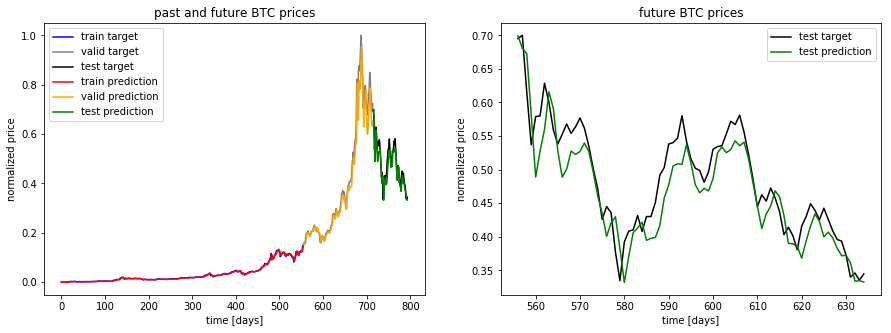

In [8]:
import matplotlib.pyplot as plt

ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_valid.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future BTC prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future BTC prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))